LISTA vs LCoD Implementation
===================

import needed packages

In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from torch.linalg import eigvalsh 
import numpy as np
import matplotlib.pyplot as plt

Fixing the Seed of the code and datatype

In [2]:
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

Creating Dataset and plotting

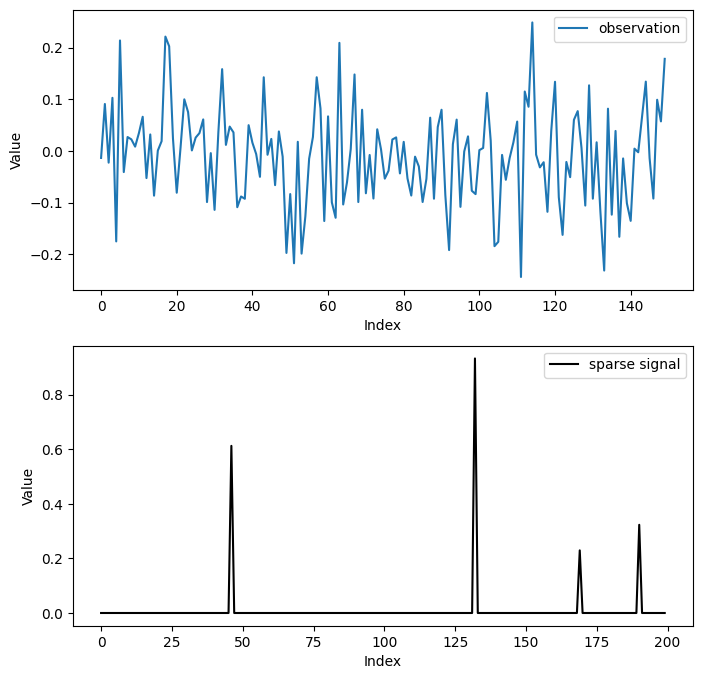

In [3]:
class SimulatedData(Data.Dataset): #Creates tuple (x, H, s) for each sample
    def __init__(self, x, H, s):
        self.x = x
        self.s = s
        self.H = H

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx, :]
        H = self.H
        s = self.s[idx, :]
        return x, H, s

def create_data_set(H, n, m, k, N=1000, batch_size=512, signal_dev=0.5, noise_dev=0.01): #function to create dataset
    # Initialization
    x = torch.zeros(N, n)
    s = torch.zeros(N, m)

    # Create signals
    for i in range(N):
        # Create a k-sparsed signal s
        index_k = np.random.choice(m, k, replace=False)
        peaks = signal_dev * np.random.randn(k)

        s[i, index_k] = torch.from_numpy(peaks).to(s)

        # X = Hs+w
        x[i, :] = H @ s[i, :] + noise_dev * torch.randn(n)

    simulated = SimulatedData(x=x, H=H, s=s)
    data_loader = Data.DataLoader(dataset=simulated, batch_size=batch_size, shuffle=True)
    return data_loader

N = 1000 # number of samples
n = 150 # dim(x)
m = 200 # dim(s)
k = 4 # k-sparse signal
T_t = 5  # Number of iterations

# Measurement matrix
H = torch.randn(n, m)
H /= torch.norm(H, dim=0)

# Generate datasets
train_loader = create_data_set(H, n=n, m=m, k=k, N=N)
test_loader = create_data_set(H, n=n, m=m, k=k, N=N, batch_size=N)

x_exm, _, s_exm =test_loader.dataset.__getitem__(5)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'sparse signal', color='k')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.show()

Training Function

In [4]:
def train(model, train_loader, valid_loader, num_epochs=50):
    """Train a network.
    Returns:
        loss_test {numpy} -- loss function values on test set
    """
    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))
    # Main loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(train_loader):
            s_hat, _ = model.forward(b_x)
            loss = F.mse_loss(s_hat, b_s, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # validation
        model.eval()
        test_loss = 0
        for step, (b_x, b_H, b_s) in enumerate(valid_loader):
            # b_x, b_H, b_x = b_x.cuda(), b_H.cuda(), b_s.cuda()
            s_hat, _ = model.forward(b_x)
            test_loss += F.mse_loss(s_hat, b_s, reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)
        # Print
        if epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

LISTA Class

In [5]:
class LISTA_Model(nn.Module):
    def __init__(self, n, m, L, T=6, rho=1.0, H=None):
        super(LISTA_Model, self).__init__()
        self.n, self.m = n, m
        self.H = H
        self.L = L
        self.T = T  # ISTA Iterations
        self.rho = rho  # Lagrangian Multiplier
        self.A = nn.Linear(n, m, bias=False)  # Weight Matrix
        self.B = nn.Linear(m, m, bias=False)  # Weight Matrix
        # ISTA Stepsizes eta
        self.beta = nn.Parameter(torch.ones(T + 1, 1, 1)/L, requires_grad=True)
        self.mu = nn.Parameter(torch.ones(T + 1, 1, 1)/L, requires_grad=True)
        # Initialization
        if H is not None:
            self.A.weight.data = H.t()
            self.B.weight.data = H.t() @ H

        '''for param in self.A.parameters(): # A needs no_grad (should not be trained)
            param.requires_grad = False
        for param in self.B.parameters():# B needs no_grad (should not be trained)
            param.requires_grad = False'''
       
    def _shrink(self, s, beta):
        return beta * F.softshrink(s / beta, lambd=self.rho)

    def forward(self, x, s_gt=None):
        mse_vs_itr = []

        s_hat = self._shrink(self.mu[0, :, :] * self.A(x), self.beta[0, :, :])
        for i in range(1, self.T + 1):
            s_hat = self._shrink(s_hat - self.mu[i, :, :] * self.B(s_hat) + self.mu[i, :, :] * self.A(x),
                                 self.beta[i, :, :], )
            
            # Aggregate each iteration's MSE loss
            if s_gt is not None:
                mse_vs_itr.append(F.mse_loss(s_hat.detach(), s_gt.detach(), reduction="sum").data.item())

        return s_hat, mse_vs_itr
  

LCoD Class

In [6]:
class LearnedCoD(nn.Module):
    def __init__(self, H, T=10, learn_alpha=True):
        super(LearnedCoD, self).__init__()
        self.T = T
        self.H = H
        self.m = H.shape[1]

        # Fixed matrices (you can make them learnable if needed)
        self.B_mat = nn.Parameter(H.T.clone(), requires_grad=False)
        self.S_mat = nn.Parameter(torch.eye(self.m, dtype=torch.float64) - H.T @ H, requires_grad=False)

        # Learnable thresholds
        if learn_alpha:
            self.alpha_list = nn.ParameterList([nn.Parameter(torch.tensor(0.05, dtype=torch.float64)) for _ in range(T)])
        else:
            self.alpha_list = [torch.tensor(0.05, dtype=torch.float64) for _ in range(T)]

    def soft_threshold(self, B, alpha):
        return torch.sign(B) * torch.maximum(torch.abs(B) - alpha, torch.zeros_like(B))

    def forward(self, x, s_gt=None):
        if x.dim() == 2 and x.shape[1] == self.H.shape[0]:
            batch_size = x.shape[0]
            z_out = []
            mse_list = []

            for i in range(batch_size):
                z_i, mse_i = self.forward(x[i].unsqueeze(1), s_gt[i].unsqueeze(1) if s_gt is not None else None)
                z_out.append(z_i.squeeze(1))  # (m, 1) -> (m,)
                if s_gt is not None:
                    mse_list.append(mse_i)

            z_out = torch.stack(z_out, dim=0)  # shape: (batch_size, m)
            if s_gt is not None:
                mse_avg = torch.stack(mse_list, dim=0).mean(dim=0)
                return z_out, mse_avg
            else:
                return z_out, None

    # Single sample mode (x shape = [n, 1])
        B = self.B_mat @ x  # shape: (m, 1)
        z = torch.zeros((self.m, 1), dtype=torch.float64, device=x.device)
        mse_vs_iter = []

        for t in range(self.T):
            z_bar = self.soft_threshold(B, self.alpha_list[t])
            k = torch.argmax(torch.abs(z - z_bar))
            delta = z_bar[k, 0] - z[k, 0]
            B = B + self.S_mat[:, [k]] * delta
            z[k, 0] = z_bar[k, 0]

            if s_gt is not None:
                mse = F.mse_loss(z.detach(), s_gt.detach(), reduction="sum").item()
                mse_vs_iter.append(mse)

        if s_gt is not None:
            return z, torch.tensor(mse_vs_iter, dtype=torch.float64)
        else:
            return z, None


LISTA Implementation(Trained)

In [7]:
  
def lista_apply(train_loader, test_loader, T, H):
    n = H.shape[0]
    m = H.shape[1]
    L=torch.abs(eigvalsh(H.T @ H)).max()
    lista = LISTA_Model(n=n, m=m, L=L, T=T, rho=.8, H=H)
    train(lista, train_loader, test_loader)
    
    # Extract all samples and calculate MSE for each iteration
    s_gt, x = test_loader.dataset.s, test_loader.dataset.x
    _, mse_vs_iter = lista(x, s_gt=s_gt)

    return np.array(mse_vs_iter)/len(test_loader.dataset)

lista_mse_vs_iter = lista_apply(train_loader, test_loader, 5, H)
print(lista_mse_vs_iter)

Epoch 0, Train loss 0.80938955, Validation loss 0.66325989
Epoch 10, Train loss 0.05195564, Validation loss 0.04889974
Epoch 20, Train loss 0.01156787, Validation loss 0.01231590
Epoch 30, Train loss 0.00256130, Validation loss 0.00314522
Epoch 40, Train loss 0.00151916, Validation loss 0.00205471
[0.40332471 0.33782266 0.15431227 0.03096971 0.0018385 ]


CoD Implementation(Trained)

In [8]:
def lcod_apply(train_loader, test_loader, T, H):
    model = LearnedCoD(H=H, T=T, learn_alpha=True)
    
    train(model, train_loader, test_loader)

    x = test_loader.dataset.x
    s_gt = test_loader.dataset.s
    mse = torch.zeros(T, dtype=torch.float64)

    for i in range(len(x)):
        _, mse_curve = model(x[i].unsqueeze(1), s_gt=s_gt[i].unsqueeze(1))
        mse += mse_curve

    mse_vs_iter = mse / len(x)
    return mse_vs_iter.numpy()


lcod_mse_vs_iter = lcod_apply(train_loader, test_loader, T_t, H=H)
print(lcod_mse_vs_iter)

Epoch 0, Train loss 0.01194853, Validation loss 0.00979596
Epoch 10, Train loss 0.00228396, Validation loss 0.00194228
Epoch 20, Train loss 0.00208550, Validation loss 0.00187168
Epoch 30, Train loss 0.00206819, Validation loss 0.00185614
Epoch 40, Train loss 0.00203433, Validation loss 0.00182944
[0.36953105 0.13427674 0.03467254 0.0041389  0.00182913]


plot LISTA vs LCoD

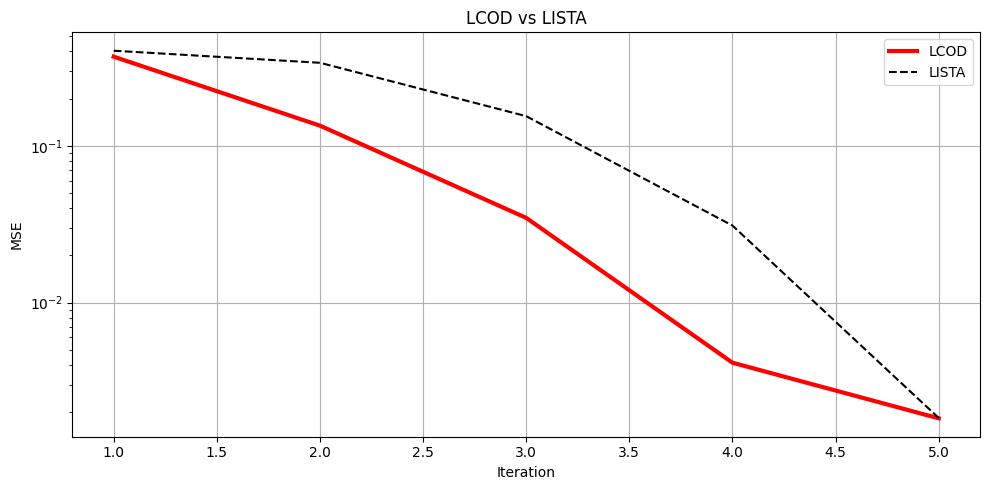

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, T_t + 1), lcod_mse_vs_iter, label="LCOD", color="red", lw=3)
plt.plot(range(1, T_t + 1), lista_mse_vs_iter, label='LISTA', color="black", ls ='--')
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.yscale('log')
plt.title("LCOD vs LISTA")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()